<a href="https://colab.research.google.com/github/mltlima/Visagio-Projeto-Final/blob/master/DataFirst_Case_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importações necessárias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from IPython.display import display
from ipywidgets import interact, IntSlider
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import holidays
import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Definição de Escopo do Problema

O cliente é uma empresa que atua no mercado de animais de estimação há mais de 10 anos. Além da venda de produtos, possui clínica veterinária e serviços estéticas em suas lojas físicas.

As vendas se concentram nas unidades físicas que estão distribuídas no Nordeste do país e, mais recentemente, digitalmente para todo o país.

O mercado Pet foi resiliente na pandemia e continuou crescendo. Muitas pessoas obtiveram seu primeiro animal de estimação enquanto em quarentena devido não só à maior atenção possível, como também pela companhia que fazem. **O CEO da Vai Pet busca saber como atacar essa fatia crescente no mercado.**

Atualmente o mercado PET brasileiro é o 4º maior do mundo, com um faturamento de R$ 23 bi e mais de 142 milhões de animais.

O mercado vê uma importante tendência de **humanização** - ou seja, o pet sai da figura de protetor, guardião, e passa a ser visto como um membro da família.

Além disso, o mercado vê um crescimento de 12% a.a. nos próximos 5 anos, em um mercado altamente fragmentado: aproximadamente 51% são pequenos pet shops, que começam a se consolidar e apresentar altos players nacionais.

O pet shop possui alta recorrência de compras - é possível ver claramente uma analogia com humanos: é necessário comprar comidas, medicamentos, produtos para banho, estética, guloseimas etc.

#Definição do Objetivo e Configuração de Métricas

O CEO, altamente analítico e orientado a resultados, deseja resposta para as seguintes perguntas:

1. Em relação à **previsão da demanda**, qual a previsão de venda diária para produtos para cães nos próximos seis meses?

2. É possível segmentar os clientes em grupos? Há algum mais rentável pela empresa?

3. Qual o grupo de clientes com maior chance de churn? Na companhia, um cliente inativo é aquele que não transaciona por mais de 90 dias.

4. Com base no comportamento e característica dos clientes, quais outros produtos, além dos que ele já compra, podem ser oferecidos?

## Possíveis ideias de configuração

Na pergunta 1 possivelmente teremos que tratar os dados, juntar as bases e agrupar os dados relevantes para depois aplicar um modelo de aprendizado supervisionado de regressão, já que trabalhamos com variável contínua.

No tópico 2 poderemos fazer uma abordagem tanto manual com aprendizagem não supervisionada, já que possuímos algumas informações que possivelmente permitem uma clusterização.

O terceiro ponto deve ser uma abordagem relativamente metódica, "straightforward", dado que é um assunto amplamente estudado. É crucial estar atento a uma base de dados bem tratadas e uma boa engenharia de dados.

Para responder à pergunta número 4, podemos atrelar aos dados uma visão fora da caixa, buscando produtos ou serviços que estão em alta no mercado e se encaixam nas características dos clientes, saindo do comum e se diferenciando dos demais players. Como auxílio podemos buscar benchmarks no mercado.

#Limpeza de Dados e Manipulação

Começamos criando as variáveis dos dados de cliente, produto e venda. Em seguida, vamos rodar um método ```.info()``` e ```.head()``` para podermos ter uma primeira visão sobre as bases.

In [ ]:
#não esqueça de fazer o upload dos arquivos para o ambiente do colab 
#antes de executar esta célula
cliente = pd.read_csv('/content/drive/Shareddrives/Grupo 01 - VAI Academy/Projeto Final/1. Kit Projeto Final/Dados/cliente.csv')
produto = pd.read_csv('/content/drive/Shareddrives/Grupo 01 - VAI Academy/Projeto Final/1. Kit Projeto Final/Dados/produto.csv')
venda = pd.read_csv('/content/drive/Shareddrives/Grupo 01 - VAI Academy/Projeto Final/1. Kit Projeto Final/Dados/venda.csv', thousands=',')

---
## Base de dados venda.csv

In [ ]:
venda.info()
print('')
venda.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859583 entries, 0 to 1859582
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID_VENDA         int64  
 1   DATA_VENDA       object 
 2   ID_CLIENTE       float64
 3   ID_PRODUTO       int64  
 4   QUANTIDADE       float64
 5   CATEGORIA_VENDA  object 
 6   FILIAL           int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 99.3+ MB



,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL
1859578,854530,2021/10/23,NaN,36642,10.0,Loja,113
1859579,854530,2021/10/23,NaN,7332,10.0,Loja,113
1859580,854530,2021/10/23,NaN,7333,10.0,Loja,113
1859581,854531,2021/10/23,106865.0,7528,1.0,Loja,113
1859582,854532,2021/10/23,NaN,8553,1.0,Loja,113


In [ ]:
#verificando valores nulos na tabela
venda.isnull().sum()

ID_VENDA                0
DATA_VENDA              0
ID_CLIENTE         929866
ID_PRODUTO              0
QUANTIDADE              0
CATEGORIA_VENDA         0
FILIAL                  0
dtype: int64

Cada coluna possui uma particularidade. Vamos analisar caso a caso.

Sabemos que a coluna **ID_VENDA** deve representar um número inteiro e positivo, que pode ser repetido ou não, mas que sempre deve ser consecutivo. Portanto, não deve haver descontinuidades de valores.

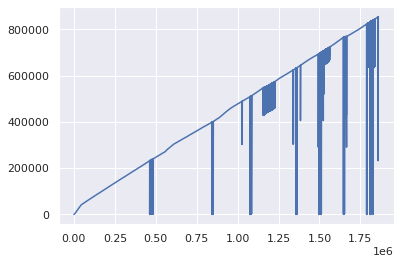

In [ ]:
#plotando os valores de ID_VENDA para ver descontinuidades
_= venda['ID_VENDA'].plot(kind='line')

In [ ]:
# Observando um caso em que há descontinuidade:
venda[venda.ID_VENDA == 0].head(4)

,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL
0,0,2021/02/10,45659.0,17631,1.0,E-COMMERCE,101
1,0,2021/02/10,45659.0,34575,1.0,E-COMMERCE,101
462811,0,2021/02/27,74218.0,285,1.0,E-COMMERCE,102
462812,0,2021/02/27,74218.0,291,1.0,E-COMMERCE,102


Notamos que em alguns casos há vendas em dias distintos que possuem o mesmo ID, o que não deveria ocorrer. Contudo, pelo plot dos IDs de venda acima, vimos que esses casos são excessão e não regra. 

A coluna **DATA_VENDA** deve ser uma data representada pelo formato "%Y/%m/%d".


In [ ]:
#transformando a coluna DATA_VENDA em datetime
venda['DATA_VENDA'] = pd.to_datetime(venda['DATA_VENDA'], format="%Y/%m/%d")

A coluna **ID_CLIENTE** deve ser composta de números naturais positivos com um valor máximo de 105923 (como visto na base de dados cliente.csv) ou valores nulos - seria o caso de um cliente não ser cadastrado na loja, por exemplo; já vimos que há valores nulos nessa coluna. Qualquer float fora desses intervalos deve ser removido. Lembrando que não é possível transformar para int porque há valores NA nessa coluna.

Como não é possível identificar qual o valor correto do ID_CLIENTE, pois variaria de caso a caso e poderia representar um possível erro. Cabe a nós avaliar as situações que seriam fora do intervalo esperado (<0 ou >105923) e ver como tratá-los.

In [ ]:
#verificando se não não valores com informações nas casas decimais não nulos
x = venda.loc[venda['ID_CLIENTE']*10%10 != 0][venda.ID_CLIENTE.notnull()]
x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL


Vimos que não há valores em ID_CLIENTE com informações nas casas decimais. Agora, vamos analisar se há valores negativos ou acima do limite.

In [ ]:
print(f'Há {venda.loc[venda.ID_CLIENTE < 0].shape[0]} valores de ID_CLIENTE menores que 0.\n')
print(f'Há {venda.loc[venda.ID_CLIENTE > 105923].shape[0]} valores de ID_CLIENTE maiores que 105923.\n')

Há 0 valores de ID_CLIENTE menores que 0.

Há 2355 valores de ID_CLIENTE maiores que 105923.



Como esses clientes não estão computados na base de dados de clientes, teríamos duas opções:

1. Adicioná-los à base de dados de cliente, supondo que a primeira compra foi quando houve a primeira ocorrência de compra na base de dados de venda;
2. Remover essa informação da base de dados de vendas.

Vamos seguir com a primeira opção pois um dos objetivos da nossa análise é vermos quais clientes têm mais chance de churn. Posteriormente será possível cruzar as informações se esses clientes são inativos ou não e quais são os produtos que eles têm interessante. Logo, a informação é relevante. 

Um argumento contrário à adição destes clientes à base é o fato de ser um montante muito pequeno (representa menos de 2.5% do total de clientes). De fato, isso é verdade. Ainda assim, optaremos por fazer a análise com a informação mais completa possível.

In [ ]:
#obtendo os ID_CLIENTE e a DATA_VENDA dos clientes com ID superior ao limite
x = venda[['ID_CLIENTE', 'DATA_VENDA']].loc[venda['ID_CLIENTE'] > 105923]

#obtendo uma série onde o index representa o ID_CLIENTE e o valor a PRIMEIRA_COMPRA
x = x.groupby('ID_CLIENTE', as_index=False)['DATA_VENDA'].first()

#renomeando a coluna DATA_VENDA para PRIMEIRA_COMPRA
x = x.rename(columns={'DATA_VENDA':'PRIMEIRA_COMPRA'})

#transformando o tipo de dados de ID_CLIENTE de float64 para int64
x['ID_CLIENTE'] = x['ID_CLIENTE'].astype('int64')

#settando os valores de ID_CLIENTE como index
x.set_index(x['ID_CLIENTE'], drop=False, inplace=True)

#adicionado um DataFrame criado de uma série na base de dados cliente.csv
cliente = cliente.append(x)

**Agora temos uma nova base de dados para cliente atualizada, que é a base que passará a ser trabalhada.**

A coluna ID_CLIENTE terminou o seu tratamento. Podemos seguir para a próxima.

A coluna **QUANTIDADE** representa quanto de cada produto foi comprado. Assim sendo, deve ser do tipo float, pois pode conter casas decimais (no caso de produtos de venda a granel, por exemplo, como ração seca, areia e granulados etc).

Além disso, não é de se esperar valores tão altos, como, por exemplo, na casa do milhão. Também não é de se esperar valores que não sejam inteiros para produtos que não comportem esse tipo de venda (não é possível comprar 1.5 caminhas, ou apenas 1.2 tosa de cão). Isso deve ser analisado também, porém, por uma questão de prioridade, realizaremos outras análises mais relevantes

In [ ]:
#transformando os valores para numérico
venda['QUANTIDADE'] = pd.to_numeric(venda['QUANTIDADE'])

### Ponto de atenção!!

**Aqui antes tinha um erro sendo gerado quando tentávamos converter para numérico. Eu descobri que possivelmente seria o separador de milhar, que era "," e esse não é o padrão do pandas. Contudo, fico me questionando se faz sentido valores tão altos de quantidade na clínica a ponto de chegar ao milhar. Uma teoria que eu tenho é que é possívelmente a fatura da conta da clínica, que foi erroneamente computada.**

**Se esse for o caso, acredito que valha a pena manter o separador como vem de default em em read_csv e quando esse error surgir, nós o retirarmos por meio de um errors='coerce', seguido de um bfill para fillna.**

O código e os comentários utilizados para o caso do parágrafo anterior continuam abaixo até que o grupo chegue num consenso.

Vemos que um erro foi gerado pois existe uma string '1,200'. Vamos entender esse dado.

In [ ]:
#venda.iloc[6635]
venda.loc[venda.ID_CLIENTE ==21617].head()

,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL
6565,4281,2020-01-06,21617.0,38309,150.0,Clínica,101
6635,4351,2020-01-07,21617.0,38309,1200.0,Clínica,101
6696,4412,2020-01-08,21617.0,38309,70.0,Clínica,101
13005,10710,2020-05-18,21617.0,38309,250.0,Clínica,101
13007,10712,2020-05-18,21617.0,38308,40.0,Estética,101


Vemos que é um produto comprado da clínica, e foram demandadas 1200 unidades dele. Não há erros depois.

Contudo, o produto 38309 não existe, porque o número máximo de linhas que existia na base de dados produto.csv antes de todo o tratamento era 38308. Logo, essa categoria ou foi um erro ou é a forma como a base de dados computou valores deixado em branco no campo de produto.

Os valores da coluna QUANTIDADE foram convertidos para float com sucesso, e os que eram string foram inseridos como o valor mais próximo válido. Isso pode gerar alguma imprecisão futura com modelos de regressão, porém seria um valor pequeno.

Por fim, a coluna **CATEGORIA_VENDA** representa o canal por onde a venda chegou. Deve conter valores únicos e qualquer erro deve ser consertado ou excluído, quando incompreensível.

In [ ]:
#verificando os valores únicos de CATEGORIA_VENDA
venda['CATEGORIA_VENDA'].unique()

array(['E-COMMERCE          ', 'Loja                ',
       'Digital             ', 'Estética            ',
       'Clínica             '], dtype=object)

Vemos que há o mesmo excesso de espaços no fim de cada categoria. Podemos facilmente eliminá-los.

In [ ]:
#removendo todos os espaços à direita até o primeiro caractere
venda['CATEGORIA_VENDA'] = venda['CATEGORIA_VENDA'].str.rstrip()

#verificando a coluna
venda['CATEGORIA_VENDA'].unique()

array(['E-COMMERCE', 'Loja', 'Digital', 'Estética', 'Clínica'],
      dtype=object)

A coluna **CATEGORIA_VENDA** está com valores corretos e pronta para análises futuras.

Por fim, temos a coluna FILIAL, que também deve conter valores únicos e que não sejam ambíguos. Vamos dar uma olhada nela.

In [ ]:
venda.FILIAL.unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113])

Excelente! Não há valores fora do esperado e ele estão todos devidamente computados. Podemos ver como ficou a base de venda após o tratamento.

In [ ]:
venda.info()
print("")
venda.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859583 entries, 0 to 1859582
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ID_VENDA         int64         
 1   DATA_VENDA       datetime64[ns]
 2   ID_CLIENTE       float64       
 3   ID_PRODUTO       int64         
 4   QUANTIDADE       float64       
 5   CATEGORIA_VENDA  object        
 6   FILIAL           int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 99.3+ MB



,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL
0,0,2021-02-10,45659.0,17631,1.0,E-COMMERCE,101
1,0,2021-02-10,45659.0,34575,1.0,E-COMMERCE,101
2,1,2021-02-12,70766.0,2240,1.0,E-COMMERCE,101
3,2,2021-02-12,42579.0,17707,1.0,E-COMMERCE,101
4,2,2021-02-12,42579.0,8952,1.0,E-COMMERCE,101


---
## Base de dados cliente.csv

In [ ]:
cliente.info()
print('')
cliente.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106866 entries, 0 to 106865
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID_CLIENTE       106866 non-null  int64 
 1   SEXO             105924 non-null  object
 2   DATA_NASCIMENTO  105924 non-null  object
 3   PRIMEIRA_COMPRA  106866 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.1+ MB



,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA
106861,106861,NaN,NaN,2021-10-23 00:00:00
106862,106862,NaN,NaN,2021-10-24 00:00:00
106863,106863,NaN,NaN,2021-10-23 00:00:00
106864,106864,NaN,NaN,2021-10-24 00:00:00
106865,106865,NaN,NaN,2021-10-23 00:00:00


Vemos que o "ID_Cliente" é igual ao index do DataFrame (o que pode nos ser útil no futuro, caso queiramos fazer um merge ou ainda apenas ter essa informação como index). Vemos também, que há alguns dados em branco no sexo. E valores não preenchidos, portanto automaticamente preenchidos, para as colunas "DATA_NASCIMENTO" e "PRIMEIRA_COMPRA".

Vemos que não há dados em branco, posto que todas as colunas possuem o mesmo número de linhas não nulas, e nem repetidos, já que esse valor é o mesmo de RangeIndex. Ainda assim, para confirmar, podemos rodar o código abaixo.

In [ ]:
#vendo se há valores duplicados
cliente[cliente.ID_CLIENTE.duplicated()]

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA


De fato, não há clientes com IDs repetidos. Podemos agora ver se há alguma linha com valores vazios.



In [ ]:
np.where(cliente.isnull())

(array([105924, 105924, 105925, ..., 106864, 106865, 106865]),
 array([1, 2, 1, ..., 2, 1, 2]))

De fato, não há nenhuma linha nula em todo o DataFrame. Contudo, vimos que há valores vazios para sexo, e talvez haja para as outras coluna também. Vamos ver se há valores que são representados por uma string vazia.

In [ ]:
a = len(cliente[cliente['SEXO'] == " "])
b = len(cliente[cliente['DATA_NASCIMENTO'] == " "])
c = len(cliente[cliente['PRIMEIRA_COMPRA'] == " "])

print(f"Há {a} strings em branco em SEXO, {b} em DATA_NASCIMENTO e {c} em PRIMEIRA_COMPRA.")

Há 59401 strings em branco em SEXO, 0 em DATA_NASCIMENTO e 0 em PRIMEIRA_COMPRA.


O que percebemos era correto. Há 59401 dados em sexo com strings vazias. Para facilitar, podemos substituir esse valor para o padrão do pandas NaN.

In [ ]:
#fazendo a substituição de strings com qualquer string que contenha apenas
#espaços vazios por np.nan
cliente = cliente.replace(r'^\s*$', np.nan, regex=True)

#verificando se a modificação teve efeito
len(cliente[cliente['SEXO'] == " "])

0

Vemos que a substituição foi feita com sucesso pois agora o valor é 0. Podemos seguir para a análise dos valores únicos na coluna de SEXO, já que suas possibilidades são bem limitadas quando comparadas às demais colunas.

In [ ]:
cliente.SEXO.unique()

array([nan, 'F', 'O', 'M', 'm', 'f'], dtype=object)

Vemos que temos mais possibilidades do que deveriam, o que é facilmente consertado. Vamos transformar tudo em letras de caixa alta.

In [ ]:
cliente = cliente.replace(['f','m'], ['F', 'M'])
cliente.SEXO.unique()

array([nan, 'F', 'O', 'M'], dtype=object)

A coluna SEXO agora possui valores únicos bem definidos e que não são ambíguos. Podemos seguir adiante.

Buscando otimizar os dados, podemos mudar o tipo das colunas.

In [ ]:
#SEXO é uma variável categórica
cliente['SEXO'] = cliente['SEXO'].astype("category")

#data de nascimento e data da primeira compra são datetimes
cliente.DATA_NASCIMENTO = pd.to_datetime(cliente.DATA_NASCIMENTO, format="%Y/%m/%d", errors='coerce')
cliente.PRIMEIRA_COMPRA = pd.to_datetime(cliente.PRIMEIRA_COMPRA, format="%Y/%m/%d")

cliente.tail()

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA
106861,106861,NaN,NaT,2021-10-23
106862,106862,NaN,NaT,2021-10-24
106863,106863,NaN,NaT,2021-10-23
106864,106864,NaN,NaT,2021-10-24
106865,106865,NaN,NaT,2021-10-23


In [ ]:
cliente.isnull().sum()

ID_CLIENTE             0
SEXO               60343
DATA_NASCIMENTO      970
PRIMEIRA_COMPRA        0
dtype: int64

Vemos que após tratar o tipo de data na coluna "DATA_NASCIMENTO", obtivemos alguns valores nulos, uma vez que utilizamos `errors = 'coerce'` no código acima.

Contudo, temos também os clientes com data de nascimento ou data de primeira compra como "1900-01-01". Sabemos que essa data não representa um dado real, portanto podemos substituir todos os valores por "NaT".

In [ ]:
#substituindo os valores das colunas DATA_NASCIMENTO e PRIMEIRA_COMPRA
cliente.loc[cliente['DATA_NASCIMENTO'] == "1900-01-01", 'DATA_NASCIMENTO'] = pd.NaT
cliente.loc[cliente['PRIMEIRA_COMPRA'] == "1900-01-01", 'PRIMEIRA_COMPRA'] = pd.NaT

cliente.head()

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA
0,0,NaN,NaT,2017-03-06
1,1,NaN,NaT,2017-03-06
2,2,NaN,NaT,2017-03-06
3,3,NaN,NaT,2017-02-18
4,4,NaN,NaT,2017-01-16


Os dados estão com devidamente categorizados. Agora devemos entender se há valores absurdos para DATA_NASCIMENTO e PRIMEIRA_COMPRA.

In [ ]:
#obtendo todos os valores não nulos na coluna DATA_NASCIMENTO em forma de series
nascimento = cliente[cliente['DATA_NASCIMENTO'].notnull()]['DATA_NASCIMENTO']

#transformando a series em um DF
nascimento = pd.DataFrame(data={'DATA_NASCIMENTO': nascimento})

#criando uma coluna com a DATA mínima de nascimento que alguém pode ter (aprox. 100 anos)
nascimento['DATA_MIN'] = pd.to_datetime('1921-01-01')

#avaliando quantos datas de nascimento estão acima de 100 anos
n = nascimento.loc[nascimento['DATA_NASCIMENTO'] < nascimento['DATA_MIN']]
n_ = n.value_counts().sum()

print(f'Há, supostamente, {n_} clientes com mais de 100 anos na base de dados')

Há, supostamente, 39 clientes com mais de 100 anos na base de dados


Sabemos que essas idades estão possivelmente erradas, porque a pessoa mais velha do mundo viveu até seus 122 anos, segundo o Guinness, [fonte aqui](https://guinnessworldrecords.com.br/news/2021/8/a-pessoa-mais-velha-do-mundo-a-viver-homem-morreu-com-uma-idade-de-113-anos).

Logo, podemos excluir esses valores de data_nascimento da nossa base de dados.

In [ ]:
#obtendo o index da datas de nascimento errado
n_index = n.index

#transformando os valores de n_index numa lista
n_index = n_index.to_list()

#loop dentro da lista n_index
for i in range(0,len(n_index)):
  #transformando a data de nascimento em pd.NaT
  cliente.iloc[n_index[i],2] = pd.NaT

Uma vez analisada a coluna de DATA_NASCIMENTO, podemos fazer o mesmo para a coluna de PRIMEIRA_COMPRA.

In [ ]:
#obtendo todos os valores não nulos na coluna PRIMEIRA_COMPRA em forma de series
pc = cliente[cliente['PRIMEIRA_COMPRA'].notnull()]['PRIMEIRA_COMPRA']

#transformando a series em um DF
pc = pd.DataFrame(data={'PRIMEIRA_COMPRA': pc})

#criando uma coluna com a DATA mínima de compra que alguém pode ter (aprox. 5 anos)
pc['DATA_MIN'] = pd.to_datetime('2016-01-01')

#avaliando quantos datas de primeira compra estão acima de 5 anos
pc2 = pc.loc[pc['PRIMEIRA_COMPRA'] < pc['DATA_MIN']]
pc2_ = pc2.value_counts().sum()

print(f'Há, {pc2_} clientes com primeira compra acima de 5 anos')

Há, 2 clientes com primeira compra acima de 5 anos


Vamos analisar esses dados.

In [ ]:
pc2

,PRIMEIRA_COMPRA,DATA_MIN
555,2001-05-03,2016-01-01
584,2014-03-11,2016-01-01


Apesar de não serem datas absurdas para alguém ter feito sua primeira compra com a companhia, esses valores estão muito fora do padrão de primeira compra dos demais clientes. Neste caso, outliers. Vamos mudar seus valores para pd.NaT a fim de que não interfira em nenhuma análise futura. 

Além disso, percebemos que há datas de primeira compra de 2001, sendo que a VAI Pet está no mercado entre 10 e 20 anos, assim, as mesmas deverão ser tratadas posteriormente.

In [ ]:
#obtendo o index da datas de primeira compra outliers
pc2_index = pc2.index

#transformando os valores de n_index numa lista
pc2_index = pc2_index.to_list()

#loop dentro da lista n_index
for i in range(0,len(pc2_index)):
  #transformando a data de nascimento em pd.NaT
  cliente.iloc[pc2_index[i],3] = pd.NaT

Vamos avaliar agora o caso do extremo oposto: clientes que fizeram sua primeira compra numa data posterior à data máxima que existe na base de dados de venda e clientes menores de 16 anos. Começaremos pelo primeiro cenário.

In [ ]:
#obtendo todos os valores não nulos na coluna PRIMEIRA_COMPRA em forma de series
pcf = cliente[cliente['PRIMEIRA_COMPRA'].notnull()]['PRIMEIRA_COMPRA']

#transformando a series em um DF
pcf = pd.DataFrame(data={'PRIMEIRA_COMPRA': pcf})

#criando uma coluna com a DATA mínima de compra que alguém pode ter (aprox. 5 anos)
pcf['DATA_MAX'] = pd.to_datetime(max(venda['DATA_VENDA']))

#avaliando quantos datas de primeira compra estão acima de 5 anos
pcf2 = pcf.loc[pcf['PRIMEIRA_COMPRA'] > pcf['DATA_MAX']]
pcf2_ = pcf2.value_counts().sum()

print(f'Há, {pcf2_} clientes que fizeram sua primeira compra no futuro')

Há, 0 clientes que fizeram sua primeira compra no futuro


Como vimos, não há nada a se preocupar sobre dados futuros. Vamos ver sobre as idades mais novas agora.

In [ ]:
#obtendo todos os valores não nulos na coluna DATA_NASCIMENTO em forma de series
n_mn = cliente[cliente['DATA_NASCIMENTO'].notnull()]['DATA_NASCIMENTO']

#transformando a series em um DF
n_mn = pd.DataFrame(data={'DATA_NASCIMENTO': n_mn})

#criando uma coluna com a DATA mínima de nascimento que alguém pode ter (aprox. 12 anos)
n_mn['DATA_MIN'] = pd.to_datetime('2009-01-01')

#avaliando quantos datas de nascimento estão abaixo de 17 anos
n_mn2 = n_mn.loc[n_mn['DATA_NASCIMENTO'] > n_mn['DATA_MIN']]
n_mn2_ = n_mn2.value_counts().sum()

print(f'Há, aproximadamente, {n_mn2_} clientes com menos de 12 anos na nossa base de dados.')

Há, aproximadamente, 796 clientes com menos de 12 anos na nossa base de dados.


Além disso, clientes com idade registrada menor que 12 serão descartados, uma vez que são apenas crianças.

In [ ]:
#obtendo o index do DF contendo clientes menores de 12 anos
n_mn2_i = n_mn2.index

#transformando para uma lista
n_mn2_i = n_mn2_i.to_list()

#loop dentro da lista n_mn2_i
for i in range(0,len(n_mn2_i)):
  #transformando a data de nascimento em pd.NaT
  cliente.iloc[n_mn2_i[i],2] = pd.NaT

Agora que foram avaliadas situações de extremos, tanto mínimos, quanto máximos, podemos criar novas colunas para a análise de dados.

Entre elas, desejamos criar uma coluna que nos dê a idade de cada cliente
 e outra que dê à qual geração esse cliente pertence (X, Y, Z etc).

In [ ]:
#criando uma coluna temp de data atual como sendo a última data de venda computada
cliente['DATA_ATUAL'] = max(venda['DATA_VENDA'])

#transformando a data em apenas data (sem as horas)
cliente['DATA_ATUAL'] = pd.to_datetime(cliente['DATA_ATUAL'])


#fazendo a diferença das datas (em timedelta)
cliente['IDADE'] = (cliente['DATA_ATUAL'] - cliente['DATA_NASCIMENTO'])

#convertemos o tempo total em dias para segundos e depois dividimos pela qtd total de segundos em um ano
cliente['IDADE'] = round(cliente['IDADE'].dt.total_seconds()/timedelta(days=365).total_seconds())

#dropando a coluna temp
cliente = cliente.drop('DATA_ATUAL', axis = 1)

Com a coluna de idade criada, podemos criar a coluna de geração. Utilizaremos como base de informações para saber a qual geração cada idade pertence [este link](https://www.beresfordresearch.com/age-range-by-generation/).

In [ ]:
#usando bins pra cada intervalo de idade
cliente['GERAÇÃO'] = pd.cut(cliente.IDADE, bins=[1,25,41,57,76,94,100], labels=['Z','Y','X','B','PG','2GM'])

#para avaliar se todos os valores de IDADE foram computados como geração
cliente.notna().sum() 

ID_CLIENTE         106866
SEXO                46523
DATA_NASCIMENTO     44482
PRIMEIRA_COMPRA    102804
IDADE               44482
GERAÇÃO             44482
dtype: int64

Em uma primeira análise podemos ver que, dos 106.7k clientes, menos da metade quis informar ou sua data de nascimento, ou seu sexo. Particularmente acreditamos que essa informação faça sentido no cenário real, dado que muitos cliente ou se preocupam com sua privacidade ou não fazem questão de informar esse dado, especialmente a data de nascimento. Ainda, com o advento das leis de LGPD, a coleta de informações irrelevantes para determinada ação se torna ainda mais perigosa para a companhia.

Além disso, há cerca de 4k clientes que não possuem a data da sua primeira compra computada, possivelmente um erro do operador que deixou o campo em branco.

Podemos também fazer uma coluna da última compra feita pelo cliente.

In [ ]:
#obtendo uma série onde o index representa o ID_CLIENTE e o valor a data de ULTIMA_COMPRA
y = venda.groupby('ID_CLIENTE', as_index=False)['DATA_VENDA'].max()

#renomeando a coluna DATA_VENDA para ULTIMA_COMPRA
y = y.rename(columns={'DATA_VENDA':'ULTIMA_COMPRA'})

# #transformando o tipo de dados de ID_CLIENTE de float64 para int64
y['ID_CLIENTE'] = y['ID_CLIENTE'].astype('int64')

#fazendo join das duas bases de dado em todos os valores em ID_CLIENTE
cliente_c = pd.merge(cliente,y,how='outer', on='ID_CLIENTE')

---
## Base de dados produto.csv

In [ ]:
produto.info()
print('')
produto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38308 entries, 0 to 38307
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PRODUTO  38308 non-null  int64 
 1   UNIDADE     38308 non-null  object
 2   NIVEL 1     38308 non-null  object
 3   NIVEL 2     38308 non-null  object
 4   NIVEL 3     38308 non-null  object
 5   NIVEL 4     38308 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB



,ID_PRODUTO,UNIDADE,NIVEL 1,NIVEL 2,NIVEL 3,NIVEL 4
0,0,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
1,1,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
2,2,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
3,3,UN,,,,
4,4,UN,CAES,FARMACIA,DORES E INFECCOES,ANTIBIOTICOS


Numa primeira análise, vemos que as colunas estão com nome contendo espaços. Vamos renomeá-las.

Observamos, também, que há linhas com informações repetidas (por exemplo, as linhas 0 a 2) e linhas com valores nulos.

Para tratar esses dados, vamos ver se esses identificadores impactam, de alguma forma, a base de dados VENDA.

In [ ]:
produto = produto.rename(columns={'NIVEL 1': 'NIVEL_1', 'NIVEL 2':'NIVEL_2', 'NIVEL 3':'NIVEL_3', 'NIVEL 4': 'NIVEL_4'})
produto.head()

,ID_PRODUTO,UNIDADE,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4
0,0,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
1,1,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
2,2,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
3,3,UN,,,,
4,4,UN,CAES,FARMACIA,DORES E INFECCOES,ANTIBIOTICOS


In [ ]:
venda.loc[venda['ID_PRODUTO'] == 1, 'ID_PRODUTO']

5979       1
59287      1
60125      1
63973      1
67443      1
          ..
1774136    1
1774187    1
1775851    1
1776744    1
1776971    1
Name: ID_PRODUTO, Length: 320, dtype: int64

In [ ]:
venda.loc[venda['ID_PRODUTO'] == 2, 'ID_PRODUTO']

52508      2
65813      2
68602      2
82777      2
82991      2
          ..
1765973    2
1777318    2
1778372    2
1779762    2
1780040    2
Name: ID_PRODUTO, Length: 198, dtype: int64

In [ ]:
venda.loc[venda['ID_PRODUTO'] == 3, 'ID_PRODUTO']

Series([], Name: ID_PRODUTO, dtype: int64)

In [ ]:
venda.loc[venda['ID_PRODUTO'] == 38307, 'ID_PRODUTO']

Series([], Name: ID_PRODUTO, dtype: int64)

In [ ]:
venda.loc[venda['ID_PRODUTO'] == 38306, 'ID_PRODUTO']

Series([], Name: ID_PRODUTO, dtype: int64)

Vemos que os valores repetidos possuem significância na base de vendas. Isso não quer dizer que **todos** os valores nulos não impactam a base de vendas. Alguns certamente devem impactar, ainda mais num universo de 20k+ produtos. 

Contudo, para fins de simplificação de análise, podemos desconsiderá-los da base e, quando dois dados não baterem, futuramente (o que pode acontecer) podemos pensar numa alternativa para tratar esses dados - como por exemplo a criação de uma categoria 'NÃO CATEGORIZADO' para todos os produtos que não possuem representação exata na base de dados de produto.

Logo, uma primeira ação que pode ser tomada é dropar as linhas que possuem todos os valores de categoria nulos. Vamos identificar quantos valores nulos existem e depois dropar.

In [ ]:
#contando a quantidade de valores nulos na tabela
produto.isnull().sum()

ID_PRODUTO    0
UNIDADE       0
NIVEL_1       0
NIVEL_2       0
NIVEL_3       0
NIVEL_4       0
dtype: int64

Nenhum valor nulo foi encontrado. Vamos testar se há strings contendo apenas espaços, que representariam valores nulos.

In [ ]:
#dropando a coluna ID_PRODUTO que possui dtype "int64" e não permite o regex
k = produto.copy(deep=True).drop('ID_PRODUTO', axis=1)

#iterando nas categorias para saber quantas strings em branco há nos níveis
for col in k:
  a = len(k[k[col].str.contains(r'^\s*$')])
  print(f"Há {a} strings em branco em {col}.")

Há 0 strings em branco em UNIDADE.
Há 12569 strings em branco em NIVEL_1.
Há 12569 strings em branco em NIVEL_2.
Há 13199 strings em branco em NIVEL_3.
Há 16906 strings em branco em NIVEL_4.


Com isso, vemos que, quanto mais aprofundamos a categoria, mais dados nulos possuímos.

Há duas possíveis interpretações para esse fato:

1. As linhas não possuem nenhuma informação. Nesse caso, e como já vimos que não há impacto na base de vendas, as linhas contendo 4 valores nulos são desprezíveis, pois representam produtos que não existem.

2. São produtos não-categorizados. Por exemplo, podemos saber que um produto é para cães (nível 1), é um alimento (nível 2), na forma de petisco (nível 3). Contudo, é algo inovador, pois é uma imitação de goma de mascar feita para cães. Logo, não há uma classificação no nível 4 para esse produto, e esse seria representado por uma nova categoria, "OUTROS".

Dessa maneira, vamos, transformar as strings em branco para NaN e dropar as linhas que possuam 4 ou mais valores nulos. Em seguida, analisaremos novamente os resultados.

In [ ]:
#substituindo valores que contenham apenas espaços por np.nan
produto = produto.replace(r'^\s*$', np.nan, regex=True)

#verificando a base de dados atualizada
produto.isnull().sum()

ID_PRODUTO        0
UNIDADE           0
NIVEL_1       12569
NIVEL_2       12569
NIVEL_3       13199
NIVEL_4       16906
dtype: int64

Assim, os demais valores nulos podemos preencher com uma nova categoria, "OUTROS". Essa categoria representa todos os produtos que nao foram categorizados em algum dos níveis.

In [ ]:
#completando valores nulos com "OUTROS"
produto.fillna(value="OUTROS", inplace=True)

É preciso garantir ainda que cada uma das variáveis esteja apenas com valores únicos preenchidos.



In [ ]:
#olhando para os valores únicos da coluna de UNIDADES
produto['UNIDADE'].unique()

array(['UN', 'PC', 'DS', 'BA', 'DP', 'FR', 'EA', 'CX', 'BS', 'SC', 'CR',
       'CT', 'FD', 'KI', 'PT', '1 ', 'DZ', 'CJ', 'MT', 'pc', 'PA', 'KG',
       'PE'], dtype=object)

Vemos que temos o valor "1 ", que é equivalente a 'UN'. Uma vez consertado, a coluna UNIDADES possuirá apenas valores únicos.

In [ ]:
#substituindo o valor
produto.loc[produto['UNIDADE'] == "1 ", 'UNIDADE'] = 'UN'
#verificando o resultado final
produto['UNIDADE'].unique()

array(['UN', 'PC', 'DS', 'BA', 'DP', 'FR', 'EA', 'CX', 'BS', 'SC', 'CR',
       'CT', 'FD', 'KI', 'PT', 'DZ', 'CJ', 'MT', 'pc', 'PA', 'KG', 'PE'],
      dtype=object)

Seguimos para a coluna NIVEL_1.

In [ ]:
produto['NIVEL_1'].unique()

array(['CAES                          ', 'OUTROS',
       'GATOS                         ', 'PESSOAS                       ',
       'AVES                          ', 'ROEDORES                      ',
       'PEIXES                        ', 'CAVALOS                       ',
       'PRIMATAS                      '], dtype=object)

Vemos que a coluna, de fato, possui apenas valores únicos, contudo ela está completa de espaços vazios após a string. Vamos removê-los.

In [ ]:
#substituindo os espaços em branco por nada ('')
produto['NIVEL_1'] = produto['NIVEL_1'].str.replace(' ', '')
#verificando o resultado final
produto['NIVEL_1'].unique()

array(['CAES', 'OUTROS', 'GATOS', 'PESSOAS', 'AVES', 'ROEDORES', 'PEIXES',
       'CAVALOS', 'PRIMATAS'], dtype=object)

Seguimos para a coluna NIVEL_2.

In [ ]:
produto['NIVEL_2'].unique()

array(['ALIMENTOS                     ', 'OUTROS',
       'FARMACIA                      ', 'ACESSORIOS                    ',
       'HIGIENE E BELEZA              ', 'CASA                          ',
       'AQUARIOS E ACESSORIOS         ', 'ANIMAL VIVO                   '],
      dtype=object)

Novamente, observamos que há um excesso de espaços em branco no final de cada categoria. Contudo, diferentemente da situação anterior, há palavras compostas, ou seja, que contém espaço no meio.

O que podemos fazer é remover os valores vazios apenas à direita do texto. Além disso, esse problema possivelmente ocorrerá nas colunas NIVEL_3 e NIVEL_4 também, então vamos aplicar para todas as colunas.

In [ ]:
#removendo os espaços em branco ao fim do texto para as colunas restantes
produto['NIVEL_2'] = produto['NIVEL_2'].str.rstrip()
produto['NIVEL_3'] = produto['NIVEL_3'].str.rstrip()
produto['NIVEL_4'] = produto['NIVEL_4'].str.rstrip()

#verificando o resultado final
produto['NIVEL_2'].unique()

array(['ALIMENTOS', 'OUTROS', 'FARMACIA', 'ACESSORIOS',
       'HIGIENE E BELEZA', 'CASA', 'AQUARIOS E ACESSORIOS', 'ANIMAL VIVO'],
      dtype=object)

A coluna está apenas com valores únicos. Podemos seguir para a coluna seguinte, NIVEL_3.

In [ ]:
produto['NIVEL_3'].unique()

array(['PETISCOS E OSSINHOS', 'OUTROS', 'DORES E INFECCOES',
       'DEMAIS MEDICAMENTOS', 'VITAMINAS E SUPLEMENTOS',
       'OLHOS E ORELHAS', 'PELE E PELAGEM',
       'PULGAS - CARRAPATOS - VERMES', 'DOCES', 'TRANSPORTE E VIAGEM',
       'BRINQUEDOS', 'RACOES', 'UTENSILIOS PARA BANHO',
       'HIGIENE E LIMPEZA', 'RACOES - FENOS - ALFAFAS', 'DECORACAO',
       'ACESSORIOS PARA ALIMENTACAO', 'INSETICIDAS E REPELENTES',
       'GAIOLAS E ACESSORIOS', 'COLEIRAS E PEITORAIS',
       'ADESTRAMENTO E COMPORTAMENTO', 'JARDIM', 'DECORACAO E ILUMINACAO',
       'PETISCOS', 'ROUPINHAS E ACESSORIOS', 'CAMINHAS E CASINHAS',
       'ACESSORIOS MEDICOS', 'BOMBAS E CONDICIONADORES', 'AQUARIOS',
       'SUPLEMENTOS E VITAMINAS', 'PORTOES - GRADES - ESCADAS',
       'SALGADOS', 'PATAS E CASCOS', 'BEBIDAS'], dtype=object)

Vemos que ela ficou completamente tratada. Podemos seguir para a última coluna, NIVEL_4.

In [ ]:
produto['NIVEL_4'].unique()

array(['BISCOITOS - BIFINHOS - SNACKS', 'OUTROS', 'ANTIBIOTICOS',
       'TRATAMENTO DIGESTIVO', 'VITAMINAS E SUPLEMENTOS',
       'ANTI-INFLAMATORIOS', 'TRATAMENTO PARA ORELHAS',
       'TRATAMENTO PARA PELE', 'ANTIPULGAS E CARRAPATOS',
       'BANHO TERAPEUTICO', 'VERMIFUGOS', 'BOLSAS DE TRANSPORTE',
       'PARA MORDER E PUXAR', 'VARINHAS - RATINHOS - BOLINHAS',
       'INTERATIVOS E EDUCATIVOS', 'RACAO SECA', 'RACAO MEDICAMENTOSA',
       'PENTES - ESCOVAS - LUVAS', 'PELUCIA - VINIL - LATEX',
       'PARA JOGAR E PEGAR', 'TAPETES HIGIENICOS', 'ELIMINADOR DE ODORES',
       'SHAMPOOS E COSMETICOS', 'COMEDOUROS E BEBEDOUROS',
       'RACAO UMIDA (SACHES E LATAS)', 'CAIXAS DE TRANSPORTE',
       'CADEIRINHAS E CAPAS PARA BANCO', 'COLEIRAS', 'CATNIP E GRAMINHAS',
       'ARRANHADORES', 'PEITORAIS', 'GUIAS',
       'CAIXAS DE AREIA E ACESSORIOS', 'ALICATES E TESOURAS',
       'HIGIENE BUCAL', 'OSSINHOS E PALITOS', 'COLETOR DE FEZES',
       'ACESSORIOS FASHION', 'ALMOFADAS E COLCHONETES

Novamente, a coluna está inteiramente tratada.

Assim, garantimos que os valores de todas as colunas da base de produtos são únicos.

A base está finalmente tratada e sua versão final pode ser vista abaixo.

In [ ]:
produto.info()
print("")
produto.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38308 entries, 0 to 38307
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PRODUTO  38308 non-null  int64 
 1   UNIDADE     38308 non-null  object
 2   NIVEL_1     38308 non-null  object
 3   NIVEL_2     38308 non-null  object
 4   NIVEL_3     38308 non-null  object
 5   NIVEL_4     38308 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB



,ID_PRODUTO,UNIDADE,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4
38303,38303,UN,OUTROS,OUTROS,OUTROS,OUTROS
38304,38304,UN,OUTROS,OUTROS,OUTROS,OUTROS
38305,38305,UN,OUTROS,OUTROS,OUTROS,OUTROS
38306,38306,UN,OUTROS,OUTROS,OUTROS,OUTROS
38307,38307,UN,OUTROS,OUTROS,OUTROS,OUTROS


#Análise Exploratória de Dados (EDA)

De maneira similar à limpeza e manipulação de dados, começaremos por uma EDA em cada base separadamente e, em seguida, na base final que foi criada.

---
## Base de dados cliente.csv

Análise da base de clientes

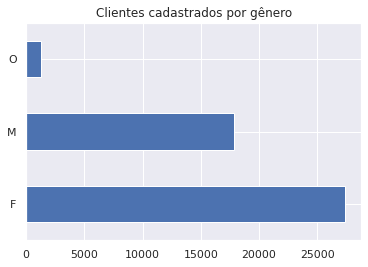

In [ ]:
#fazendo alguns gráficos iniciais
_= cliente['SEXO'].value_counts().plot(kind='barh', title='Clientes cadastrados por gênero', grid=True)

Neste gráfico de barras temos o gênero dos clientes que compõe a base da VAI Pet, sendo a maior parte do gênero feminino

In [ ]:
cliente['SEXO'].value_counts()

F    27384
M    17832
O     1307
Name: SEXO, dtype: int64

In [ ]:
# Transformando gênero e geracao em dummie
genero = pd.get_dummies(cliente.SEXO)
c2 = pd.concat([cliente,genero], axis=1)
geracao = pd.get_dummies(cliente['GERAÇÃO'])
c3 = pd.concat([c2,geracao], axis=1)
cliente_dummie = c3.drop(columns=['SEXO','GERAÇÃO'])


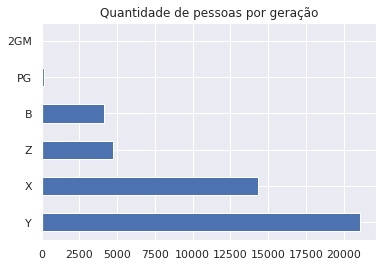

In [ ]:
# Quantidade de clientes por geração
_=cliente['GERAÇÃO'].value_counts().plot(kind='barh')
_=plt.title('Quantidade de pessoas por geração')

---
## Base de dados produto.csv

Podemos fazer uma análise a partir da quantidade de produtos que existem por categoria.

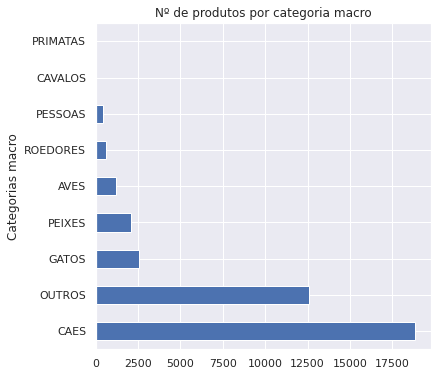

In [ ]:
_= produto['NIVEL_1'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(6,6), ylabel='Quantidade de produtos', xlabel='Categorias macro', title='Nº de produtos por categoria macro')

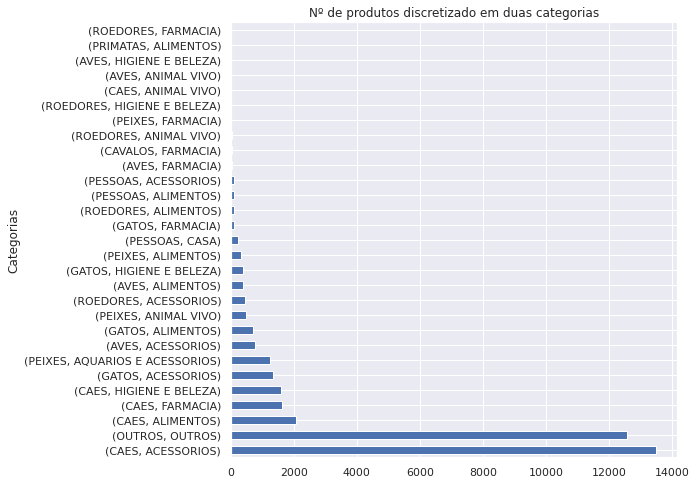

In [ ]:
_= produto.groupby('NIVEL_1')['NIVEL_2'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(8,8), ylabel='Quantidade de produtos', xlabel='Categorias', title='Nº de produtos discretizado em duas categorias')

Vemos claramente que a grande maioria de produtos é de acessórios de cães, seguido de alimentos, farmárcia e 'higiene e beleza', também para cães.


## Base de dados venda.csv

In [ ]:
# Qtd de vendas realizadas para cada filial

filialVendas = pd.DataFrame(venda.groupby('FILIAL').count()['ID_VENDA'])
filialVendas.columns = ['QTD_TOTAL_VENDAS']
filialVendas.head()

,QTD_TOTAL_VENDAS
FILIAL,
101,462792
102,379464
103,233542
104,280065
105,139958


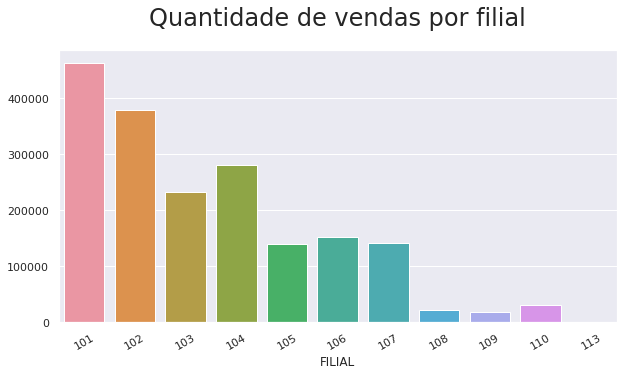

In [ ]:
#plotando qtd de vendas por filial

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=filialVendas.index, y='QTD_TOTAL_VENDAS', data=filialVendas)
plt.ylabel("")
plt.xlabel("FILIAL")
plt.xticks(rotation=30, horizontalalignment='center')
plt.yticks(rotation=0)
plt.title("Quantidade de vendas por filial", pad=25, fontsize=24)
plt.show()

In [ ]:
# Categoria de venda mais utilizada:

categoriaVenda = venda['CATEGORIA_VENDA'].value_counts()
categoriaVenda.head()

Loja          1698909
Estética        91187
Clínica         37179
E-COMMERCE      18101
Digital         14207
Name: CATEGORIA_VENDA, dtype: int64

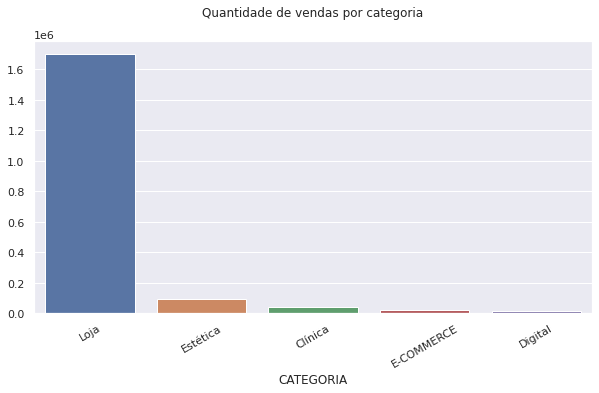

In [ ]:
# Plot de quantidade de vendas por categoria de venda 

fig, ax = plt.subplots(figsize=(10, 5))
store_sells_plot = sns.barplot(x=categoriaVenda.index, y=categoriaVenda.values)
plt.ylabel("")
plt.xlabel("CATEGORIA")
plt.xticks(rotation=30, horizontalalignment='center')
plt.yticks(rotation=0)
plt.title("Quantidade de vendas por categoria", pad=25)
plt.show(store_sells_plot)

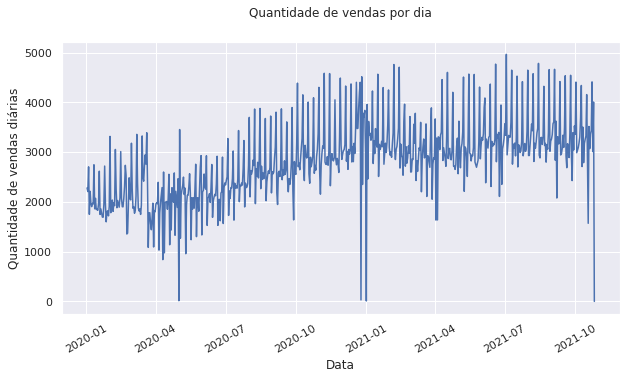

In [ ]:
# Qtd vendas diárias:

quantVenda = venda.groupby('DATA_VENDA').count()['ID_VENDA']
quantVenda.head()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=quantVenda)
plt.ylabel("Quantidade de vendas diárias")
plt.xlabel("Data")
plt.xticks(rotation=30, horizontalalignment='center')
plt.yticks(rotation=0)
plt.title("Quantidade de vendas por dia", pad=25)
plt.show()

Notamos uma clara sazonalidade e uma certa tendência de crescimento.

In [ ]:
# Setando a filial como dado categórico
venda.FILIAL = venda.FILIAL.astype('category')

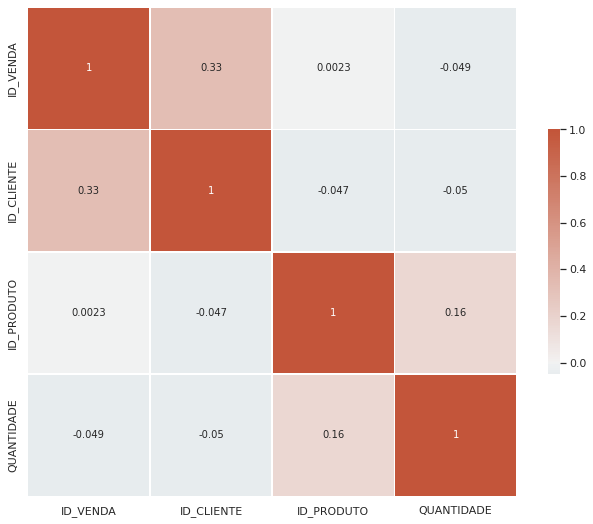

In [ ]:
# Computa a matriz de correlação da base de vendas
corr = venda.corr()
fifg, ax = plt.subplots(figsize=(11, 9))

# Gerando um colormap customizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_=sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Não foram encontradas correlações tão claras neste momento da análise exploratória.

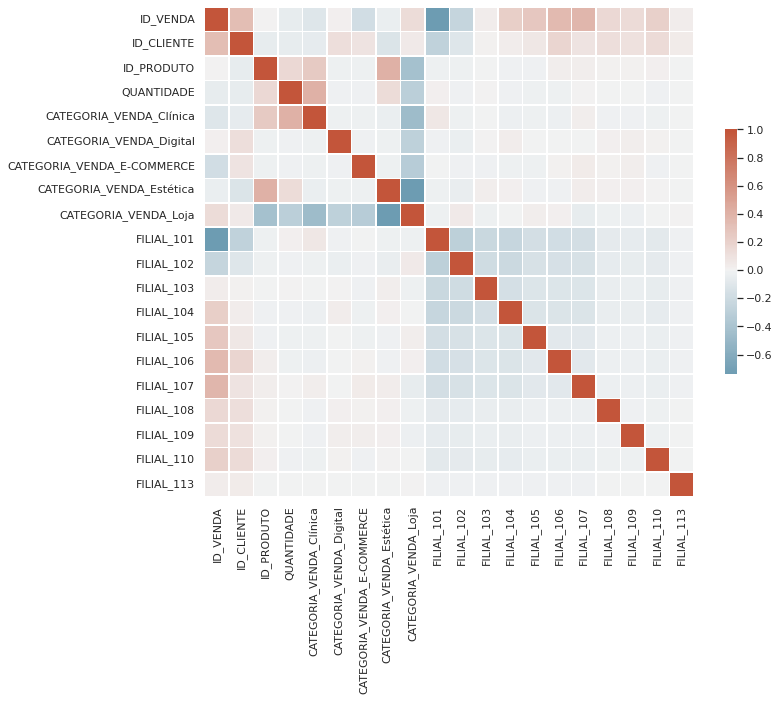

In [ ]:
# Computa a matriz de correlação da base de vendas com variáveis dummies no lugar das categóricas
df_labeled = pd.get_dummies(venda)
corr = df_labeled.corr()
fifg, ax = plt.subplots(figsize=(11, 9))

# Gerando o mapeamento de cores
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_=sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Previsão de demanda

Queremos saber qual a demanda diária de pordutos para cães nos próximos 6 meses.

In [ ]:
# Visualizando qtd produtos tem cada área
produto['NIVEL_1'].value_counts()

CAES        18809
OUTROS      12569
GATOS        2568
PEIXES       2088
AVES         1225
ROEDORES      596
PESSOAS       411
CAVALOS        39
PRIMATAS        3
Name: NIVEL_1, dtype: int64

Como prever a demanda?

Começamos selecionando as vendas de produtos de cães.

Para isso, devemos juntar os datasets de vendas e produtos.

In [ ]:
# Merge de vendas com produtos
df_demanda = venda.merge(produto, how='left', on='ID_PRODUTO')
df_demanda.head(3)

,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL,UNIDADE,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4
0,0,2021-02-10,45659.0,17631,1.0,E-COMMERCE,101,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
1,0,2021-02-10,45659.0,34575,1.0,E-COMMERCE,101,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS
2,1,2021-02-12,70766.0,2240,1.0,E-COMMERCE,101,UN,CAES,ACESSORIOS,CAMINHAS E CASINHAS,ALMOFADAS E COLCHONETES


In [ ]:
# Selecionando apenas vendas de produtos pra cães
df_demanda = df_demanda[df_demanda['NIVEL_1'] == "CAES"]

In [ ]:
# Agrupando vendas por dia
df_group = df_demanda.groupby('DATA_VENDA').apply(lambda x: x.QUANTIDADE.sum())

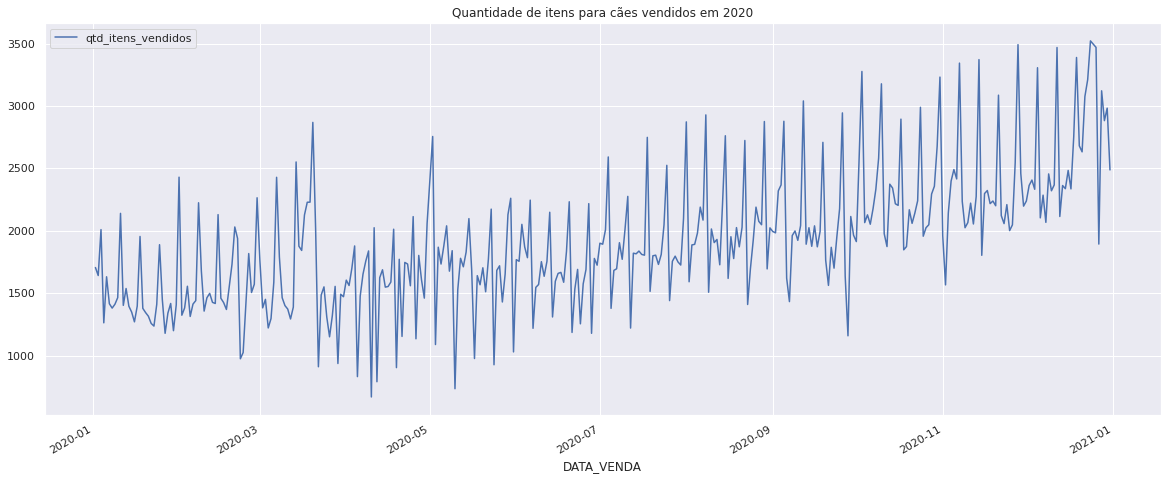

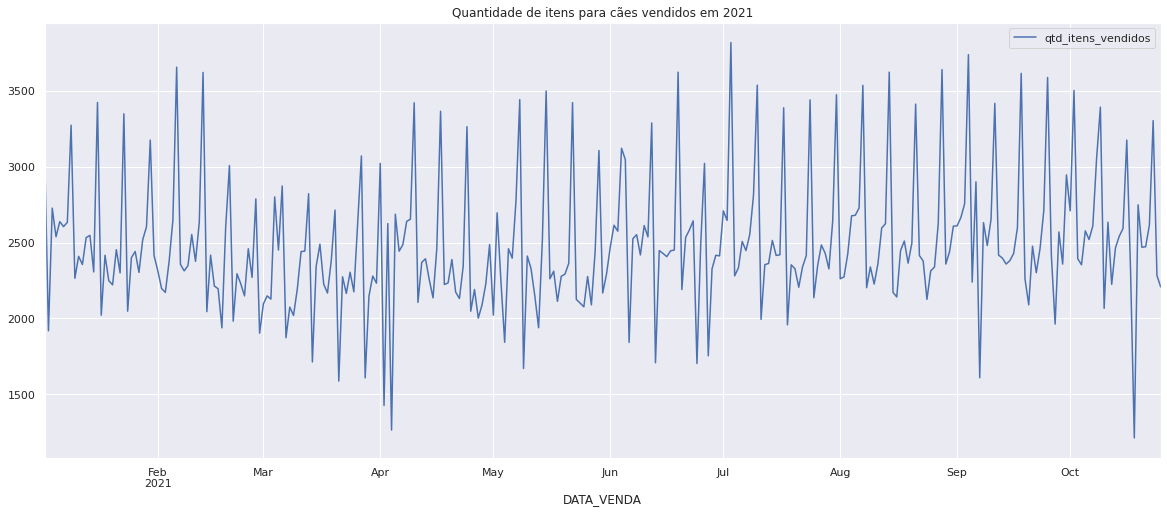

In [ ]:
# Visualizando qtd de itens de "cães" vendidos
df_group = pd.DataFrame(df_group, columns=['qtd_itens_vendidos'])
_=df_group.loc['2020'].plot(figsize=(20,8), title="Quantidade de itens para cães vendidos em 2020")
_=df_group.loc['2021'].plot(figsize=(20,8), title="Quantidade de itens para cães vendidos em 2021")

In [ ]:
# Dia da semana
df_group['dayofweek'] = df_group.index.weekday

In [ ]:
# Pegando a data dos sábados
get_sabados=df_group[df_group.dayofweek == 5].loc['2021-08'].index
get_sabados

DatetimeIndex(['2021-08-07', '2021-08-14', '2021-08-21', '2021-08-28'], dtype='datetime64[ns]', name='DATA_VENDA', freq=None)

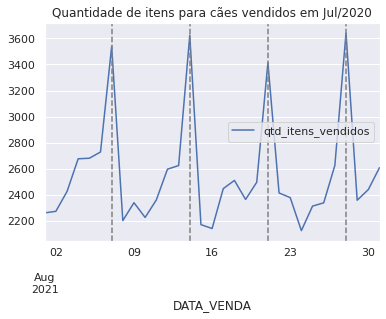

In [ ]:
# plotando um mês de exemplo
_=df_group[['qtd_itens_vendidos']].loc['2021-08'].plot(title="Quantidade de itens para cães vendidos em Jul/2020")

#linha vertical nos sábados:
_=plt.axvline('2021-08-07', color='gray', linestyle="--")
_=plt.axvline('2021-08-14', color='gray', linestyle="--")
_=plt.axvline('2021-08-21', color='gray', linestyle="--")
_=plt.axvline('2021-08-28', color='gray', linestyle="--")

Notamos um claro pico de vendas nos finais de semana, indicando que a feature "dayofweek" deve ser bastante interessante. 

Também notamos que as semanas tendem a apresentar sazonalidade, com isso, aplica-se um lag para avaliar a autocorrelação da quantidade de vendas.



In [ ]:
# aplicando lag
df_group['lag_6months'] = df_group.qtd_itens_vendidos.shift(180) # 6 meses
df_group['lag_26weeks'] = df_group.qtd_itens_vendidos.shift(26*7) #26 semanas

No lugar do número de dayofweek, utilizaremos o valor médio de vendas nesse dia.

In [ ]:
segunda,terca,quarta,quinta,sexta,sabado,domingo = df_group.groupby('dayofweek').mean().qtd_itens_vendidos

df_group.dayofweek.replace(0,segunda, inplace=True)
df_group.dayofweek.replace(1,terca, inplace=True)
df_group.dayofweek.replace(2,quarta, inplace=True)
df_group.dayofweek.replace(3,quinta, inplace=True)
df_group.dayofweek.replace(4,sexta, inplace=True)
df_group.dayofweek.replace(5,sabado, inplace=True)
df_group.dayofweek.replace(6,domingo, inplace=True)

In [ ]:
#Busca feriados brasileiros
dates_of_holidays = []
for date, name in sorted(holidays.Brazil(years=[2020, 2021]).items()):
    dates_of_holidays.append(date)

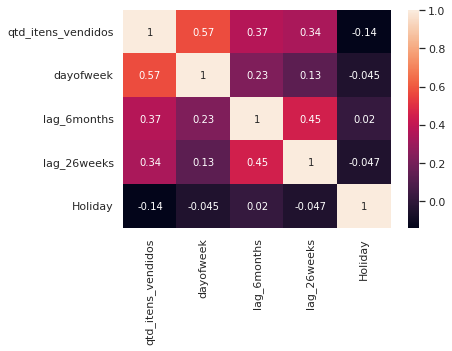

In [ ]:
# Heatmap com correlação

df_group.reset_index(inplace=True)
df_group.reset_index()
df_group["Holiday"] = df_group.DATA_VENDA.apply(lambda t: 1 if t.date() in dates_of_holidays else 0)
df_group = df_group.set_index('DATA_VENDA')
_=sns.heatmap(df_group.corr(), annot=True)

Notamos que o lag de 6 meses é melhor, portanto manteremos o manteremos

In [ ]:
#dropando lag de 26 semanas
df_group.drop(columns=['lag_26weeks'], inplace=True)

In [ ]:
# construindo modelo de ML

#Split treino teste:

start_train = "2020-07-02"
end_train = "2021-06-27"
start_test = "2021-06-28"
end_test = "2021-10-25"

df_train = df_group[start_train:end_train]
df_test = df_group[start_test:end_test]
X_train = df_train.drop(columns=["qtd_itens_vendidos"])
y_train = df_train["qtd_itens_vendidos"]
X_test = df_test.drop(columns=["qtd_itens_vendidos"])
y_test = df_test["qtd_itens_vendidos"]

In [ ]:
#Gridsearch
cv = TimeSeriesSplit(n_splits=5)

parameters = {"learning_rate": [0.1, 0.05],
              #The learning rate is the shrinkage you do at every step you are making

               "gamma" : [0.01, 0.1, 0.3, 0.5],
              #A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
              #Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
              
               "max_depth": [2, 4, 7, 10],
              #The maximum depth of a tree, same as GBM.
              #Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

               "colsample_bytree": [0.3, 0.6],
              #Denotes the fraction of columns to be randomly samples for each tree.

               "subsample": [0.2, 0.4, 0.5],
              #Denotes the fraction of observations to be randomly samples for each tree.
              #Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

               "reg_alpha": [0, 0.5, 1],
              #L1 regularization term on weights. Increasing this value will make model more conservative.

               "reg_lambda": [1, 1.5, 2, 3, 4.5],
              #L2 regularization term on weights. Increasing this value will make model more conservative.

               "min_child_weight": [1, 3, 5, 7],
              #The larger min_child_weight is, the more conservative the algorithm will be.

               "n_estimators": [100, 250, 500]}
              #Number of tress or rounds. The more, the higher the risk of overfitting

xgbr = xgb.XGBRegressor(objective='reg:squarederror')

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgbr,
                              param_distributions=parameters,
                              verbose=3,
                              random_state=42,
                              cv=cv)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.178 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-0.367 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.290 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.494 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.559 to

In [ ]:
#melhores estimadores
model_xgboost.best_estimator_

XGBRegressor(colsample_bytree=0.3, gamma=0.01, max_depth=4, min_child_weight=5,
             n_estimators=250, objective='reg:squarederror', reg_lambda=1.5,
             subsample=0.5)

In [ ]:
# Observando predição na base de treino
predict = model_xgboost.predict(X_train)
comparison = pd.DataFrame(y_train)
comparison['predict'] = predict
comparison.index = pd.to_datetime(comparison.index)

Text(0, 0.5, 'Quantidade de itens vendidos')

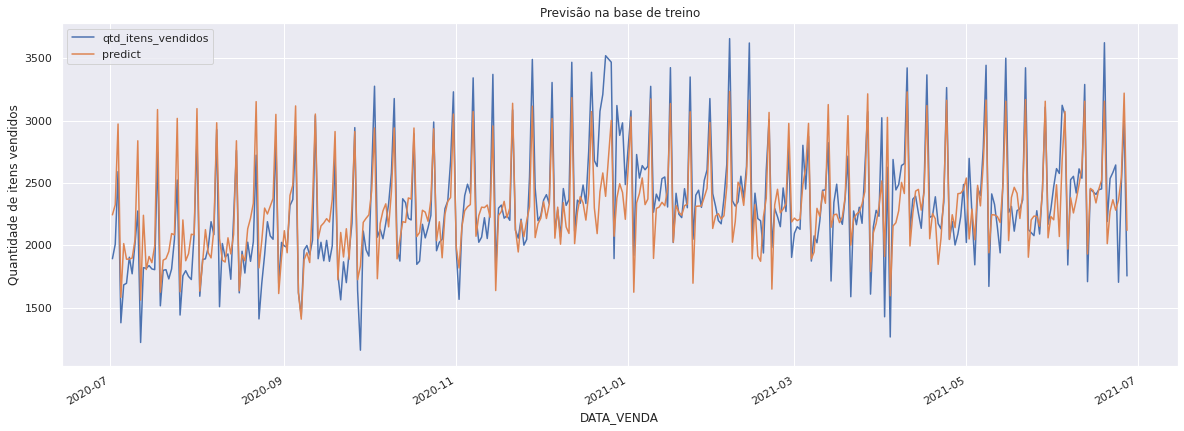

In [ ]:
#Comparando base de treino
_=comparison.plot(figsize=(20,7))
plt.title('Previsão na base de treino')
plt.ylabel('Quantidade de itens vendidos')

Text(0, 0.5, 'Quantidade de itens vendidos')

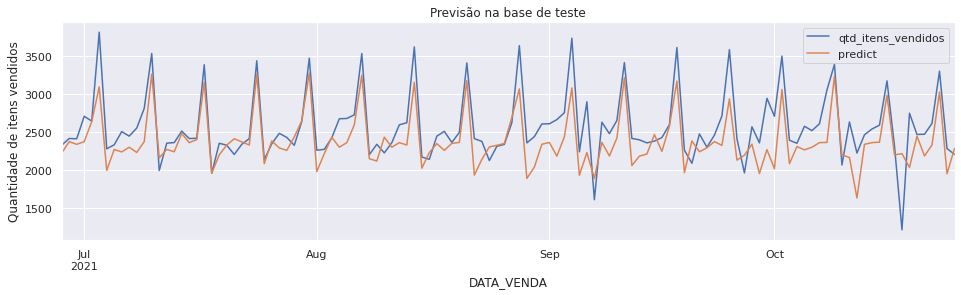

In [ ]:
#Comparando base de teste

predict = model_xgboost.predict(X_test)
compara = pd.DataFrame(y_test)
compara['predict'] = predict
_=compara.plot(figsize=(16,4))
plt.title('Previsão na base de teste')
plt.ylabel('Quantidade de itens vendidos')

### Previsão para os próximos 6 meses

In [ ]:
# Criando entrada:

df_prox6 = df_group.iloc[(658-180):658]
df_prox6['lag_6months'] = df_group.iloc[(658-180):658].qtd_itens_vendidos
df_prox6.drop(columns=['qtd_itens_vendidos'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Quantidade de itens vendidos')

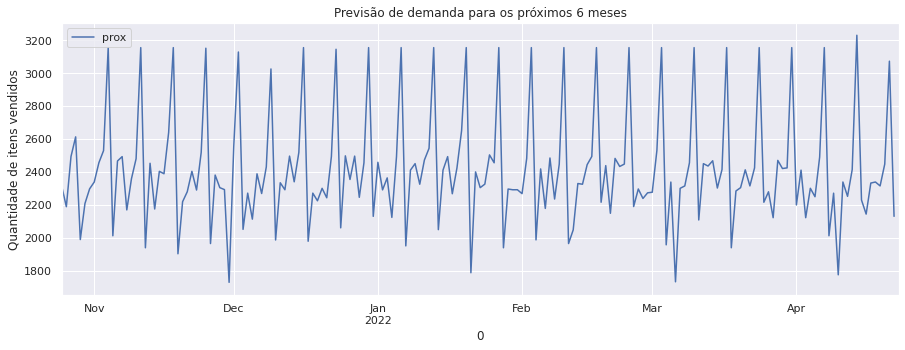

In [ ]:
# Realizando previsão dos próximos 6 meses
prox = pd.Series(model_xgboost.predict(df_prox6))
previsao6 = pd.DataFrame(pd.date_range(start='2021/10/25', end='2022/04/23'))
previsao6['prox'] = prox
_=previsao6.set_index(0).plot(figsize=(15,5))
plt.title('Previsão de demanda para os próximos 6 meses')
plt.ylabel('Quantidade de itens vendidos')

## Análise de Churn e Retenção de clientes

O cálculo do churn é feito a partir da última data de venda que temos na base de dados de venda, subtraído da última data de compra registrado pelo cliente.

Vamos fazer uma engenharia de variáveis para que possamos encontrar o churn da Vai Pet.

In [ ]:
#"a" representa o primeiro e "b" representa o último dia de vendas registrado na base
a, b = venda['DATA_VENDA'].min().date(), venda['DATA_VENDA'].max().date()
print(f'A primeira venda foi feita dia {a} e a última venda foi feita dia {b}')

A primeira venda foi feita dia 2020-01-02 e a última venda foi feita dia 2021-10-26


In [ ]:
#transformando b em datetime
hoje = pd.to_datetime(b)

#calculando a diferença das datas e transformando em dias
cliente_c['DIAS_INATIVO'] = (hoje - cliente_c['ULTIMA_COMPRA']).apply(lambda x: x.days)

In [ ]:
#fazendo análise de sobrevivência
cliente_c.loc[cliente_c['DIAS_INATIVO'] > 90, 'CATEGORIA'] = 'CHURN' #cliente churn
cliente_c.loc[cliente_c['DIAS_INATIVO'] <= 90, 'CATEGORIA'] = 'SOBREVIVEU' #cliente sobrevivente

In [ ]:
cliente_c[cliente_c.ULTIMA_COMPRA.notnull()].head(5)

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO,ULTIMA_COMPRA,DIAS_INATIVO,CATEGORIA
7,7,NaN,NaT,2017-03-07,NaN,NaN,2021-05-08,171.0,CHURN
11,11,NaN,NaT,2017-03-07,NaN,NaN,2021-02-10,258.0,CHURN
13,13,NaN,NaT,2017-03-08,NaN,NaN,2020-04-24,550.0,CHURN
15,15,NaN,NaT,2019-05-11,NaN,NaN,2021-08-10,77.0,SOBREVIVEU
20,20,NaN,NaT,2020-07-31,NaN,NaN,2021-10-13,13.0,SOBREVIVEU


In [ ]:
clientes_sob = len(cliente_c[cliente_c.CATEGORIA == "SOBREVIVEU"])

print(f'Temos {clientes_sob} clientes com recorrência menor que 90 dias, num universo de {cliente_c.shape[0]} clientes')

Temos 43267 clientes com recorrência menor que 90 dias, num universo de 106866 clientes


In [ ]:
#cálculo do churn
sobrevivencia = clientes_sob/cliente_c[cliente_c.ULTIMA_COMPRA.notnull()].shape[0]
taxa_churn = (1 - sobrevivencia)*100

print(f'Temos uma taxa de churn equivalente a {round(taxa_churn,2)}%')

Temos uma taxa de churn equivalente a 51.68%


In [ ]:
churn = cliente_c[cliente_c.ULTIMA_COMPRA.notnull()]
churn = churn[churn.CATEGORIA == 'CHURN']

In [ ]:
# base de clientes total
cliente.SEXO.value_counts(normalize=True)

F    0.588612
M    0.383294
O    0.028094
Name: SEXO, dtype: float64

In [ ]:
# base de clientes que deram churn
churn.SEXO.value_counts(normalize=True)

F    0.579505
M    0.397989
O    0.022506
Name: SEXO, dtype: float64

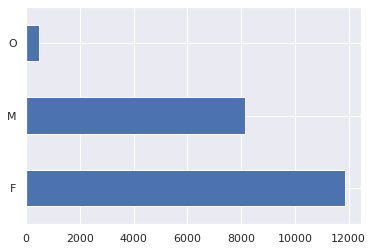

In [ ]:
# Sexo
_=churn.SEXO.value_counts().plot(kind='barh')

In [ ]:
# base de clientes total
cliente['GERAÇÃO'].value_counts(normalize=True)

Y      0.474552
X      0.322333
Z      0.106560
B      0.092712
PG     0.003754
2GM    0.000090
Name: GERAÇÃO, dtype: float64

In [ ]:
# base de clientes churn
churn['GERAÇÃO'].value_counts(normalize=True)

Y      0.493702
X      0.306530
Z      0.108928
B      0.087918
PG     0.002821
2GM    0.000101
Name: GERAÇÃO, dtype: float64

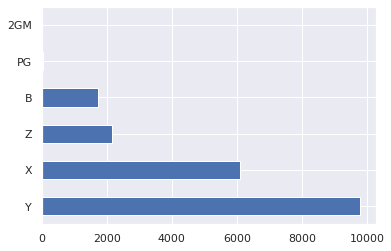

In [ ]:
# GERAÇÃO
_=churn['GERAÇÃO'].value_counts().plot(kind='barh')

Dadas as análises, observamos um churn maior na parcela da geração Y (25 a 40 anos), e também em maior parte pelo gênero feminino, o qual já era proporcionalmente maior na base de origem.

#Segmentação de Clientes

### Sem considerar idade como feature

Para realizar a segmentação de clientes, devemos criar features de interesse e que resultem em clusters interpretáveis. Com isso, pretendemos utilizar as seguintes features para cada cliente:

* Recência
* Frequência
* Quantidade média por compra

In [ ]:
# Merge do dataset de vendas com o de clientes:
df_segment = venda.merge(cliente, how='left', on='ID_CLIENTE')
df_segment.head(3)

,ID_VENDA,DATA_VENDA,ID_CLIENTE,ID_PRODUTO,QUANTIDADE,CATEGORIA_VENDA,FILIAL,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO
0,0,2021-02-10,45659.0,17631,1.0,E-COMMERCE,101,M,1985-07-31,2020-09-08,36.0,Y
1,0,2021-02-10,45659.0,34575,1.0,E-COMMERCE,101,M,1985-07-31,2020-09-08,36.0,Y
2,1,2021-02-12,70766.0,2240,1.0,E-COMMERCE,101,NaN,NaT,2021-02-12,NaN,NaN


In [ ]:
#Dropando um outlier que possui quantidades absurdas de itens comprados
df_segment = df_segment[df_segment.ID_CLIENTE != 16695]

In [ ]:
# Dropando linhas com ID de cliente nulo:
df_segment.dropna(axis = 0, subset=['ID_CLIENTE'], inplace = True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Última data da base de dados
last_date = venda.DATA_VENDA.max()

In [ ]:
# Função que irá calcular recência, freq e qtd total de produtos comprados:

def get_cluster_features(df):
    
    recencia = last_date - df.DATA_VENDA.max()
    freq = df['DATA_VENDA'].count()
    qtd_total = df.QUANTIDADE.sum()
    d = {'RENCENCIA':recencia,'FREQUENCIA':freq,'QTD_TOTAL':qtd_total}
    
    return pd.Series(d, index=['RENCENCIA', 'FREQUENCIA','QTD_TOTAL'])

In [ ]:
# Agrupando clientes e computando features

df_seg_group = df_segment.groupby('ID_CLIENTE', as_index=False).apply(get_cluster_features)

In [ ]:
# Convertendo ID_CLIENTE em inteiro, tirando a palavra "days de recência" e convertendo em inteiro:

df_seg_group.ID_CLIENTE = df_seg_group.ID_CLIENTE.apply(lambda x: int(x))
df_seg_group.RENCENCIA = df_seg_group.RENCENCIA.dt.days
df_seg_group.head()

,ID_CLIENTE,RENCENCIA,FREQUENCIA,QTD_TOTAL
0,7,171,4,197.0
1,11,258,7,8.0
2,13,550,2,2.0
3,15,77,9,3807.0
4,20,13,94,202.0


Análise de correlação das features:

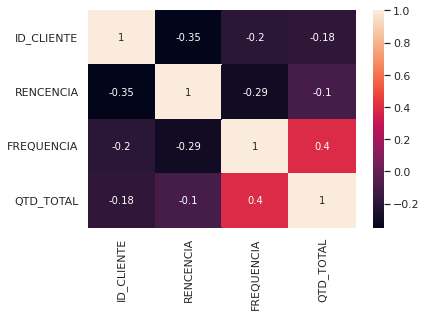

In [ ]:
_=sns.heatmap(df_seg_group.corr(),annot=True)

Notamos que quanto menor a recência, maiores são a frequência e qtd_total compradas.

E também notamos uma alta correlação entre quantidade total de itens compradas e frequência de compra.

In [ ]:
# Base utilizada para clusterização

df_cluster = df_seg_group.set_index('ID_CLIENTE')

# Normalização das variáveis
std_data = StandardScaler().fit_transform(df_cluster)
df_cluster = pd.DataFrame(data=std_data, columns=df_cluster.columns, index=df_cluster.index)

df_cluster.describe()

,RENCENCIA,FREQUENCIA,QTD_TOTAL
count,8.953400e+04,8.953400e+04,8.953400e+04
mean,7.806294e-15,-2.921523e-14,-9.702346e-15
std,1.000006e+00,1.000006e+00,1.000006e+00
min,-9.951863e-01,-5.388508e-01,-2.901424e-01
25%,-7.994981e-01,-4.814253e-01,-2.853910e-01
50%,-3.624612e-01,-3.091485e-01,-2.727206e-01
75%,5.703191e-01,9.283056e-02,-1.555191e-01
max,3.329522e+00,9.719949e+01,5.475434e+01


In [ ]:
# Cálculo das iterações do k-means (Cotovelo)

wcss = {}
for k in range(1, 15):
  print(k)
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200, random_state=3)
  kmeans.fit(df_cluster)
  wcss[k] = kmeans.inertia_

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
fig = make_subplots(
    rows=1,
    cols=1,
    subplot_titles=['Método do Cotovelo'],
    shared_xaxes=True,
    shared_yaxes=False)


fig.add_trace(
    go.Scatter(
        x=list(wcss.keys()),
        y=list(wcss.values()),
        mode='lines+markers',
        textposition='top center',
        showlegend=False),
    row=1, 
    col=1)

fig.update_xaxes(visible=True, title='No. of clusters',row=1, col=1)
fig.update_yaxes(visible=True, title='Cluster Inertia',row=1, col=1)

fig.update_layout(
  title='Definição do Nº Ideal de Clusters',
  showlegend=False,
  xaxis_showticklabels=True,
  height=400,
  width=800,
  xaxis = dict(
    tickmode = 'linear',
    tick0 = 0,
    dtick = 1))

fig.show()

In [ ]:
# Definição do DF a ser Clusterizado
df_cluster_km = df_cluster.copy()

# Clusterização
clus = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=3)
clus.fit(df_cluster_km)

# Ajustando as colunas
df_cluster_km.loc[:, 'CLUSTER'] = clus.labels_
df_cluster_km.head()

,RENCENCIA,FREQUENCIA,QTD_TOTAL,CLUSTER
ID_CLIENTE,,,,
7,0.120236,-0.366574,0.021867,2
11,0.687732,-0.194297,-0.277472,0
13,2.592430,-0.481425,-0.286975,0
15,-0.492920,-0.079446,5.739400,1
20,-0.910388,4.801728,0.029786,1


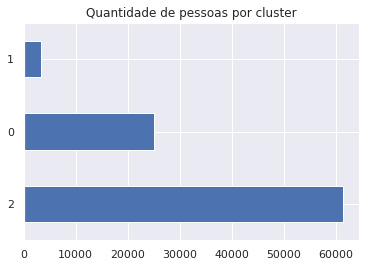

In [ ]:
# Volumetria por Categoricas
df_cluster_km['CLUSTER'].value_counts().plot(kind="barh")
plt.title('Quantidade de pessoas por cluster')
plt.show()


In [ ]:
# Novo df para análise de clusters:

segmentados = df_seg_group.set_index('ID_CLIENTE')
segmentados['CLUSTER'] = df_cluster_km['CLUSTER']
segmentados.head()

,RENCENCIA,FREQUENCIA,QTD_TOTAL,CLUSTER
ID_CLIENTE,,,,
7,171,4,197.0,2
11,258,7,8.0,0
13,550,2,2.0,0
15,77,9,3807.0,1
20,13,94,202.0,1


In [ ]:
# Coordenadas paralelas
mean_seg = segmentados.groupby(['CLUSTER']).mean()
mean_seg

,RENCENCIA,FREQUENCIA,QTD_TOTAL
CLUSTER,,,
0,363.074544,3.666173,87.682242
1,40.956641,61.244885,2373.113344
2,72.663196,10.404802,105.093021


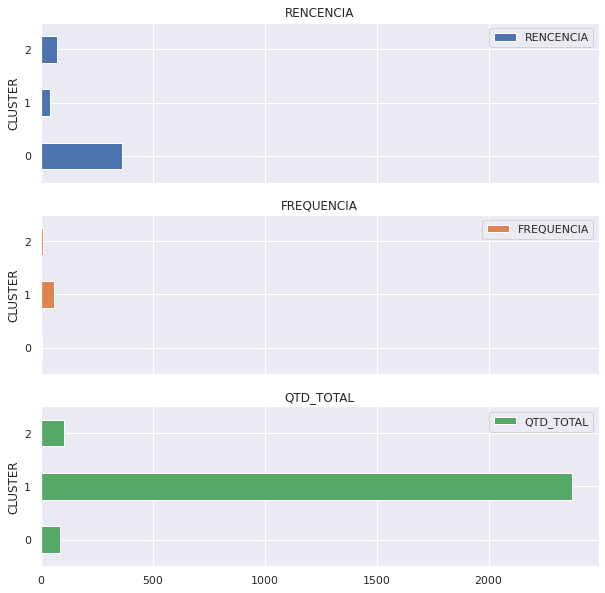

In [ ]:
_=mean_seg.plot(kind='barh', subplots=True, figsize=(10,10))

Assim, analisaremos 3 clusters:

* Cluster 0: baixa frequência de compra, e recência grande => potenciais clientes que darão churn.
* Cluster 1: clientes mais regulares, possuem recência média de 73 dias, frequência de 10 vezes, e quantidade total de itens comprados de 96.
* Cluster 2: clientes assíduos, compram com frequência alta, recência baixa e em grande quantidade (são um grupo pequeno, mas deve ser aproveitado).

In [ ]:
# Coordenadas Paralelas
fig = px.parallel_coordinates(segmentados, color="CLUSTER")
fig.update_layout(
    title={
        'text': "Cluster analysis",
        'y':1
        },
    height=500,
    width=1000)
fig.show()

In [ ]:
# Coordenadas Paralelas
fig = px.parallel_coordinates(segmentados.groupby(['CLUSTER']).mean().reset_index(), color="CLUSTER")
fig.update_layout(
    title={
        'text': "Cluster analysis",
        'y':1
        },
    height=500,
    width=1000)
fig.show()

## Recomendação de Produtos

### Dados de tempo

In [ ]:
cliente_c.head()

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO,ULTIMA_COMPRA,DIAS_INATIVO,CATEGORIA
0,0,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN
1,1,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN
2,2,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN
3,3,NaN,NaT,2017-02-18,NaN,NaN,NaT,NaN,NaN
4,4,NaN,NaT,2017-01-16,NaN,NaN,NaT,NaN,NaN


In [ ]:
cliente_c_copy = cliente_c.copy()

cliente_c_copy['Seconds'] = cliente_c.ULTIMA_COMPRA.dt.second
cliente_c_copy['Minutes'] = cliente_c.ULTIMA_COMPRA.dt.minute
cliente_c_copy['Hour'] = cliente_c.ULTIMA_COMPRA.dt.hour
cliente_c_copy['Day_Week'] = cliente_c.ULTIMA_COMPRA.dt.weekday
cliente_c_copy['Day_Month'] = cliente_c.ULTIMA_COMPRA.dt.day
cliente_c_copy['Day_Year'] = cliente_c.ULTIMA_COMPRA.dt.dayofyear
cliente_c_copy['Week'] = cliente_c.ULTIMA_COMPRA.dt.week
cliente_c_copy['Month'] = cliente_c.ULTIMA_COMPRA.dt.month
cliente_c_copy['Quarter'] = cliente_c.ULTIMA_COMPRA.dt.quarter
cliente_c_copy['Year'] = cliente_c.ULTIMA_COMPRA.dt.year

cliente_c_copy.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO,ULTIMA_COMPRA,DIAS_INATIVO,CATEGORIA,Seconds,Minutes,Hour,Day_Week,Day_Month,Day_Year,Week,Month,Quarter,Year
0,0,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaT,2017-02-18,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaT,2017-01-16,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#print(cliente_c_copy['Seconds'].unique())
#print(cliente_c_copy['Minutes'].unique())
#print(cliente_c_copy['Hour'].unique())
print(cliente_c_copy['Day_Week'].unique())
#print(cliente_c_copy['Day_Month'].unique()) 
#print(cliente_c_copy['Day_Year'].unique())
#print(cliente_c_copy['Week'].unique())
print(cliente_c_copy['Month'].unique())
print(cliente_c_copy['Quarter'].unique()) 
print(cliente_c_copy['Year'].unique())

[nan  5.  2.  4.  1.  0.  6.  3.]
[nan  5.  2.  4.  8. 10.  9.  7.  1.  6. 12. 11.  3.]
[nan  2.  1.  3.  4.]
[  nan 2021. 2020.]


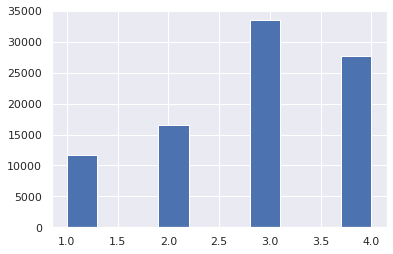

In [ ]:
cliente_c_copy['Quarter'].hist()

Podemos verificar que os ultimos 6 meses sao os mais movimentados, vamos verificar a analise mes a mes

### Evolucao de clientes ativos mes a mes

In [ ]:
venda_produto = pd.merge(produto, venda,how='outer', on='ID_PRODUTO')
cliente_compra = pd.merge(venda_produto, cliente_c,how='outer', on='ID_CLIENTE')

In [ ]:
# Calculo do mes do pedido por cliente unico (avaliacao mes a mes de janeiro de 2020 a outubro de 2021)
cliente_c['MES_COMPRA'] = cliente_c['ULTIMA_COMPRA'].dt.to_period('M')
clientes_ativos = cliente_c.groupby(['MES_COMPRA'], as_index=False).agg({'ID_CLIENTE': pd.Series.nunique})
clientes_ativos

,MES_COMPRA,ID_CLIENTE
0,2020-01,615
1,2020-02,612
2,2020-03,593
3,2020-04,652
4,2020-05,811
5,2020-06,793
6,2020-07,1149
7,2020-08,1664
8,2020-09,1706
9,2020-10,1975


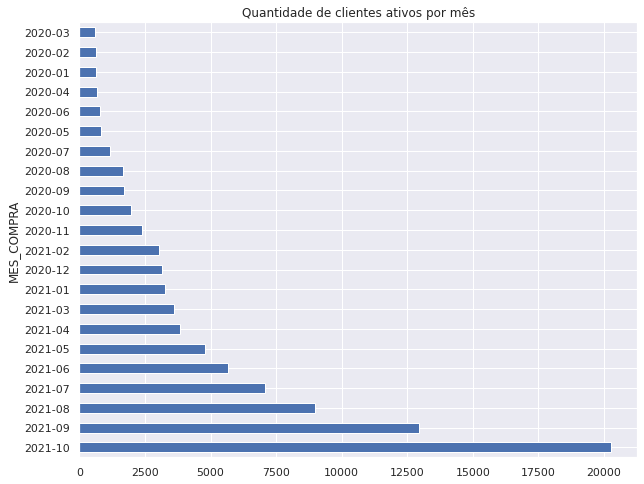

In [ ]:
clientes_ativos.groupby(['MES_COMPRA'])['ID_CLIENTE'].sum().sort_values(ascending=False).plot(kind='barh', stacked=True, figsize=(10,8), title='Quantidade de clientes ativos por mês')

Percebemos que no ano de 2021, principalmente no período de Ou seja, em outubro de 2021 tivemos cerca de 20.000 clientes ativos 

In [ ]:
cliente_c_copy

,ID_CLIENTE,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO,ULTIMA_COMPRA,DIAS_INATIVO,CATEGORIA,Seconds,Minutes,Hour,Day_Week,Day_Month,Day_Year,Week,Month,Quarter,Year
0,0,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaT,2017-03-06,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaT,2017-02-18,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaT,2017-01-16,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106861,106861,NaN,NaT,2021-10-23,NaN,NaN,2021-10-23,3.0,SOBREVIVEU,0.0,0.0,0.0,5.0,23.0,296.0,42.0,10.0,4.0,2021.0
106862,106862,NaN,NaT,2021-10-24,NaN,NaN,2021-10-24,2.0,SOBREVIVEU,0.0,0.0,0.0,6.0,24.0,297.0,42.0,10.0,4.0,2021.0
106863,106863,NaN,NaT,2021-10-23,NaN,NaN,2021-10-23,3.0,SOBREVIVEU,0.0,0.0,0.0,5.0,23.0,296.0,42.0,10.0,4.0,2021.0
106864,106864,NaN,NaT,2021-10-24,NaN,NaN,2021-10-24,2.0,SOBREVIVEU,0.0,0.0,0.0,6.0,24.0,297.0,42.0,10.0,4.0,2021.0


In [ ]:
cliente_compra.head(3)

,ID_PRODUTO,UNIDADE,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4,ID_VENDA,DATA_VENDA,ID_CLIENTE,QUANTIDADE,CATEGORIA_VENDA,FILIAL,SEXO,DATA_NASCIMENTO,PRIMEIRA_COMPRA,IDADE,GERAÇÃO,ULTIMA_COMPRA,DIAS_INATIVO,CATEGORIA
0,0.0,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS,53498.0,2020-02-04,NaN,1.0,Loja,101,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN
1,0.0,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS,67320.0,2020-03-18,NaN,1.0,Loja,101,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN
2,0.0,UN,CAES,ALIMENTOS,PETISCOS E OSSINHOS,BISCOITOS - BIFINHOS - SNACKS,70823.0,2020-03-28,NaN,1.0,Loja,101,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN


In [ ]:
cliente_compra['CATEGORIA_VENDA'].unique()

array(['Loja', nan, 'Digital', 'Estética', 'Clínica', 'E-COMMERCE'],
      dtype=object)

In [ ]:
cliente_compra['CATEGORIA_VENDA'].unique()

array(['Loja', nan, 'Digital', 'Estética', 'Clínica', 'E-COMMERCE'],
      dtype=object)

In [ ]:
cliente.isnull().sum()

ID_CLIENTE             0
SEXO               60343
DATA_NASCIMENTO    62384
PRIMEIRA_COMPRA     4062
IDADE              62384
GERAÇÃO            62384
dtype: int64